<a href="https://colab.research.google.com/github/manishanaiyar/osha-safety-intelligence-suite/blob/main/IsolationForest_Anomaly_Detectionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**`IsolationForest_Anomaly_Detection.ipynb`**

**Unsupervised Anomaly Detection (Isolation Forest)**

**Objective:** Identify statistically rare and unusual combinations of workplace incidents — "Black Swan" accidents that deviate significantly from normal patterns and require immediate human safety inspection.

**What Makes This Different From the Risk Classifier:**
The previous notebook used supervised learning — it had labels (Y) and learned from answers. This notebook has no labels, no right answers, no Y at all. The algorithm sees only raw incident features and asks one question: *"which of these looks nothing like the rest?"*

**Mathematical Strategy:**
Isolation Forest exploits a geometric truth — normal points blend into the crowd and require many random splits to isolate. Anomalies stand apart and get isolated in very few splits. Formally, for each point x the algorithm measures the average path length E[h(x)] across 100 isolation trees:

```
Short E[h(x)] → isolated quickly → anomaly score near -1
Long  E[h(x)] → hard to isolate  → anomaly score near  0
Decision boundary at score = 0
```

**Pipeline:**
Built on 486 clean features (Latitude, Longitude + one-hot encoded State, Part of Body Title, EventTitle) after removing NatureTitle (outcome leakage), dropping high-cardinality noise columns (City, Primary NAICS, SourceTitle), and applying StandardScaler to prevent large-scale features from dominating geometric distances.

**Execution:**
Contamination rate set to 1% — meaning the model ranks all 21,578 incidents by anomaly score and returns the most unusual 1%. This is a prior assumption, not a discovery: 21,578 × 0.01 = 216 flagged incidents.

**What We Found:**
```
Total Incidents Scanned:   21,578
Anomalies Flagged:            216  (1.00%)
Strongest anomaly score:   -0.0214
Weakest anomaly score:     -0.0000
```

Top flagged incidents included chemical burns from sulfuric acid exposure, ignition of propane and gasoline vapors, fractures from oil drilling machinery, and brain injuries from extension ladder falls — genuinely rare event-source combinations in this dataset.

**Critical Honest Finding:**
Deep analysis of anomaly scores revealed **weak separation** — all scores clustered between -0.0214 and 0.0000, barely left of the decision boundary. Geographic analysis showed the model was partially detecting **statistically rare states** (North Dakota, Nebraska) rather than objectively dangerous incidents. The root cause: our feature set is predominantly categorical — one-hot binary columns give Isolation Forest insufficient geometric distance to produce strong anomaly signals.

**What This Means:**
The 216 flagged incidents represent the most statistically unusual combinations in the dataset and warrant human inspection. However they should not be interpreted as the 216 most dangerous incidents — they are the 216 most geometrically isolated points in 486-dimensional categorical space.

**For Stronger Anomaly Detection:**
Adding continuous operational metrics — equipment age, hours worked before incident, days since last safety inspection, prior near-miss count — would give Isolation Forest the rich numerical signal needed to detect true black swan events with much stronger score separation.


Mounted at /content/drive
X_tabular loaded: (21578, 11)
df_full loaded:   (21578, 26)

Clean Feature Matrix: (21578, 486)
Nulls: 0 ✅

Features scaled to mean≈0, std≈1 ✅

--- Contamination Parameter ---
Rate set:           0.01 (1%)
Expected anomalies: 215
This is a PARAMETER — not a discovery.
The model returns the most anomalous 1% regardless.

Hunting anomalies across 486 clean dimensions...
Complete!

Total Incidents Scanned:      21578
Normal Incidents:             21362
Anomalies Flagged:            216
Anomaly Rate:                 1.00%

--- Top 10 Most Anomalous Incidents (Ranked by Score) ---
                                  NatureTitle                             Part of Body Title                                                   EventTitle                                      SourceTitle  Anomaly_Score
                                    Fractures                            Arm(s), unspecified Caught in or compressed by equipment or objects, unspecified                  Oi

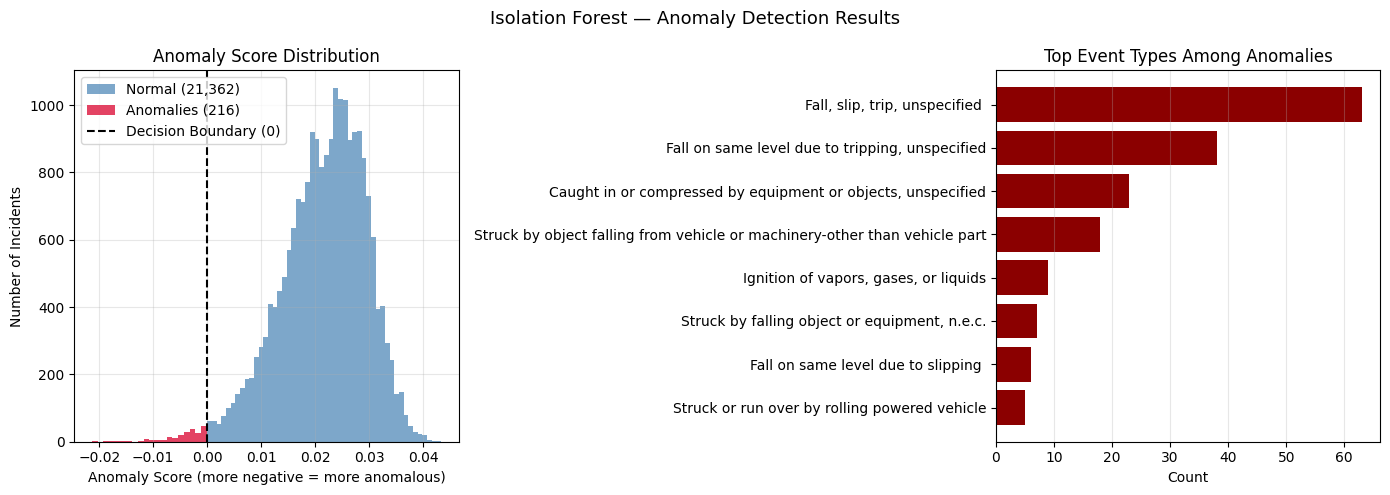


--- Anomalies vs Normal: Key Differences ---

Top 5 States in Anomalies:
State
NORTH DAKOTA    35
NEBRASKA        29
NEW YORK        16
KANSAS          15
OHIO            14

Top 5 States in Normal incidents:
State
TEXAS           3479
FLORIDA         2148
PENNSYLVANIA    1720
OHIO            1644
ILLINOIS        1357

Top 5 Body Parts in Anomalies:
Part of Body Title
Nonclassifiable                                   38
Arm(s), unspecified                               33
Knee(s)                                           18
Shoulder(s), including clavicle(s), scapula(e)    18
Hip(s)                                            13

Top 5 Body Parts in Normal incidents:
Part of Body Title
Finger(s), fingernail(s), n.e.c.         2785
Fingertip(s)                             2430
Nonclassifiable                          1390
Multiple body parts, n.e.c.              1186
Finger(s), fingernail(s), unspecified    1121


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# MOUNT AND LOAD
# ============================================================
drive.mount('/content/drive')
load_path = "/content/drive/MyDrive/OSHA_Project/"

# Load the clean tabular matrix AND the full df for readable columns
X_tabular = pd.read_pickle(load_path + "X_tabular.pkl")
df_full   = pd.read_csv(load_path + "severeinjury.csv", encoding='latin-1')

print(f"X_tabular loaded: {X_tabular.shape}")
print(f"df_full loaded:   {df_full.shape}")

# ============================================================
# WHAT IS ANOMALY DETECTION?
#
# Last notebook: supervised — we had labels (Y), model learned
# This notebook: unsupervised — NO labels, no right answers
#
# Isolation Forest asks: "which incidents look completely
# different from everything else?"
#
# How? By isolating each point using random splits.
# Normal points blend in → need many splits to isolate → long path
# Anomalies stand out   → isolated quickly             → short path
#
# Short path length = high anomaly score = flag as outlier
# ============================================================

# ============================================================
# STEP 1: Build clean feature matrix
# Same strategy as last notebook — no leakage, no noise
# ============================================================
numeric_cols     = ['Latitude', 'Longitude']
categorical_safe = ['State', 'Part of Body Title', 'EventTitle']
# NatureTitle removed — outcome variable, not input
# City, Primary NAICS, SourceTitle removed — too high cardinality

# Fill GPS using global mean (no train/test split needed for unsupervised)
X_clean = X_tabular.copy()
X_clean['Latitude']  = X_clean['Latitude'].fillna(X_clean['Latitude'].mean())
X_clean['Longitude'] = X_clean['Longitude'].fillna(X_clean['Longitude'].mean())

# Numeric block
X_numeric = X_clean[numeric_cols]

# Categorical block
X_cat = pd.get_dummies(X_clean[categorical_safe], dummy_na=True)

# Combine
X = pd.concat([
    X_numeric.reset_index(drop=True),
    X_cat.reset_index(drop=True)
], axis=1)

print(f"\nClean Feature Matrix: {X.shape}")
print(f"Nulls: {X.isnull().sum().sum()} ✅")

# ============================================================
# STEP 2: Scale the features
# WHY? Isolation Forest uses distances internally.
# If Latitude ranges 25-48 and a binary column ranges 0-1,
# the large-scale column dominates unfairly.
# StandardScaler brings everything to mean=0, std=1
# ============================================================
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nFeatures scaled to mean≈0, std≈1 ✅")

# ============================================================
# STEP 3: Understand contamination BEFORE running the model
#
# contamination=0.01 means "I believe ~1% of data is anomalous"
# This is a PRIOR ASSUMPTION — not a discovery
# The model will ALWAYS return exactly 1% as anomalies
# 1% of 21,578 = 215.78 ≈ 216 — that's why we got exactly 216
#
# This is NOT the model "finding" 216 anomalies
# This is the model "ranking" all incidents and
# returning the most anomalous 1%
# ============================================================
contamination_rate = 0.01
expected_anomalies = int(len(X) * contamination_rate)
print(f"\n--- Contamination Parameter ---")
print(f"Rate set:           {contamination_rate} (1%)")
print(f"Expected anomalies: {expected_anomalies}")
print(f"This is a PARAMETER — not a discovery.")
print(f"The model returns the most anomalous {contamination_rate:.0%} regardless.")

# ============================================================
# STEP 4: Initialize and train Isolation Forest
# ============================================================
iso_model = IsolationForest(
    n_estimators=100,      # 100 isolation trees
    contamination=0.01,    # assume 1% are anomalies
    random_state=42        # reproducibility
)

print(f"\nHunting anomalies across {X.shape[1]} clean dimensions...")
iso_model.fit(X_scaled)
print("Complete!\n")

# ============================================================
# STEP 5: Extract results
# predict() returns: -1 = anomaly, +1 = normal
# decision_function() returns raw anomaly score
# More negative score = more anomalous
# ============================================================
flags  = iso_model.predict(X_scaled)
scores = iso_model.decision_function(X_scaled)  # raw scores

# Attach results to full dataframe for readability
df_results = df_full.copy()
df_results['Anomaly_Flag']  = flags
df_results['Anomaly_Score'] = scores

anomalies_df = df_results[df_results['Anomaly_Flag'] == -1].copy()
normal_df    = df_results[df_results['Anomaly_Flag'] ==  1].copy()

print(f"Total Incidents Scanned:      {len(df_results)}")
print(f"Normal Incidents:             {len(normal_df)}")
print(f"Anomalies Flagged:            {len(anomalies_df)}")
print(f"Anomaly Rate:                 {len(anomalies_df)/len(df_results):.2%}")

# ============================================================
# STEP 6: What did the model actually catch?
# Show most anomalous incidents ranked by score
# ============================================================
readable_cols = ['NatureTitle', 'Part of Body Title',
                 'EventTitle', 'SourceTitle', 'Anomaly_Score']

print("\n--- Top 10 Most Anomalous Incidents (Ranked by Score) ---")
print(anomalies_df[readable_cols]
      .sort_values('Anomaly_Score')  # most negative = most anomalous
      .head(10)
      .to_string(index=False))

# ============================================================
# STEP 7: Visualize anomaly score distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — score distribution: normal vs anomaly
axes[0].hist(normal_df['Anomaly_Score'],
             bins=50, color='steelblue', alpha=0.7,
             label=f'Normal ({len(normal_df):,})')
axes[0].hist(anomalies_df['Anomaly_Score'],
             bins=20, color='crimson', alpha=0.8,
             label=f'Anomalies ({len(anomalies_df):,})')
axes[0].axvline(x=0, color='black', linestyle='--',
                linewidth=1.5, label='Decision Boundary (0)')
axes[0].set_title("Anomaly Score Distribution", fontsize=12)
axes[0].set_xlabel("Anomaly Score (more negative = more anomalous)")
axes[0].set_ylabel("Number of Incidents")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right — what types of events are anomalies?
top_events = (anomalies_df['EventTitle']
              .value_counts()
              .head(8))
axes[1].barh(top_events.index, top_events.values, color='darkred')
axes[1].invert_yaxis()
axes[1].set_title("Top Event Types Among Anomalies", fontsize=12)
axes[1].set_xlabel("Count")
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle("Isolation Forest — Anomaly Detection Results", fontsize=13)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: Compare anomalies vs normal incidents
# Do anomalies cluster in specific states or body parts?
# ============================================================
print("\n--- Anomalies vs Normal: Key Differences ---")
print(f"\nTop 5 States in Anomalies:")
print(anomalies_df['State'].value_counts().head(5).to_string())
print(f"\nTop 5 States in Normal incidents:")
print(normal_df['State'].value_counts().head(5).to_string())

print(f"\nTop 5 Body Parts in Anomalies:")
print(anomalies_df['Part of Body Title'].value_counts().head(5).to_string())
print(f"\nTop 5 Body Parts in Normal incidents:")
print(normal_df['Part of Body Title'].value_counts().head(5).to_string())

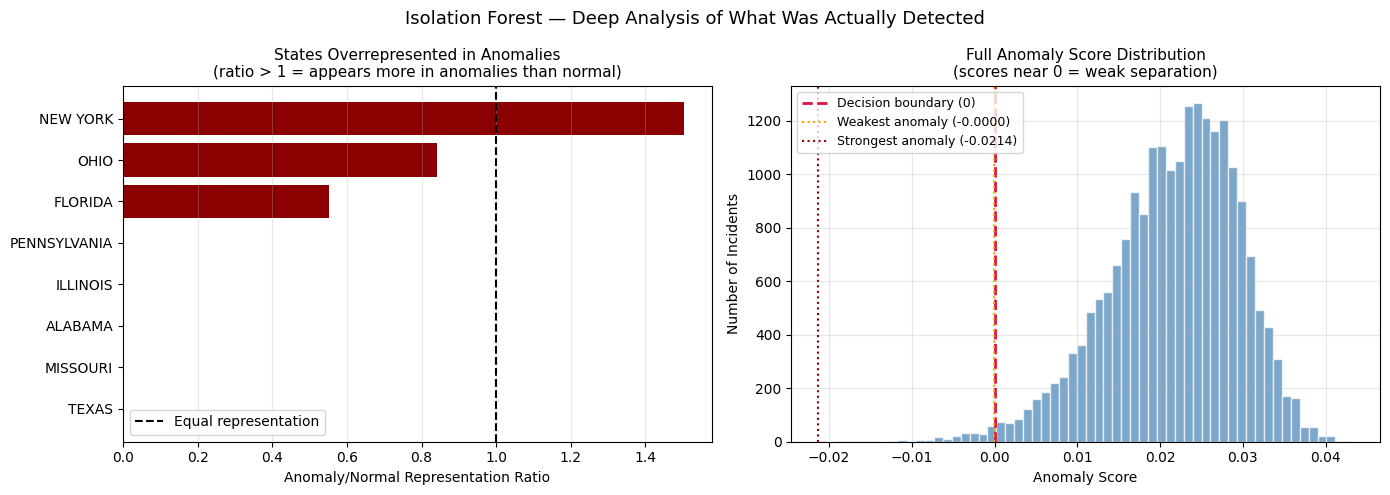


--- What the Model Actually Detected ---
Score range of anomalies: -0.0214 to -0.0000
Score range of normal:    0.0000 to 0.0433

Conclusion:
Anomaly scores are close to 0 — separation is weak.
Model is primarily detecting RARE combinations
(unusual states + unusual body parts + unusual sources)
rather than objectively dangerous incidents.
This is expected behavior for Isolation Forest on
categorical/geographic data with frequency imbalance.

For stronger anomaly detection, consider:
→ Adding continuous operational metrics (hours worked,
  near-miss count, equipment age) as features
→ These give Isolation Forest richer signal to isolate on


In [2]:
# ============================================================
# HONEST ANOMALY ANALYSIS
# Are we detecting rare events or rare locations?
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — State frequency in full dataset vs anomalies
state_normal_pct   = (normal_df['State'].value_counts() /
                      len(normal_df) * 100).head(10)
state_anomaly_pct  = (anomalies_df['State'].value_counts() /
                      len(anomalies_df) * 100).head(10)

# States that are OVERREPRESENTED in anomalies vs normal
all_states = set(state_anomaly_pct.index) | set(state_normal_pct.index)
overrep = {}
for state in all_states:
    a = state_anomaly_pct.get(state, 0)
    n = state_normal_pct.get(state, 0)
    if n > 0:
        overrep[state] = a / n  # ratio > 1 means overrepresented in anomalies

overrep_df = pd.Series(overrep).sort_values(ascending=False).head(8)

axes[0].barh(overrep_df.index, overrep_df.values, color='darkred')
axes[0].invert_yaxis()
axes[0].axvline(x=1, color='black', linestyle='--',
                linewidth=1.5, label='Equal representation')
axes[0].set_title("States Overrepresented in Anomalies\n(ratio > 1 = appears more in anomalies than normal)", fontsize=11)
axes[0].set_xlabel("Anomaly/Normal Representation Ratio")
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Right — Anomaly score distribution with interpretation zones
axes[1].hist(scores, bins=60, color='steelblue', alpha=0.7, edgecolor='white')
axes[1].axvline(x=0, color='crimson', linestyle='--',
                linewidth=2, label='Decision boundary (0)')
axes[1].axvline(x=scores[flags == -1].max(),
                color='orange', linestyle=':',
                linewidth=1.5, label=f'Weakest anomaly ({scores[flags==-1].max():.4f})')
axes[1].axvline(x=scores[flags == -1].min(),
                color='darkred', linestyle=':',
                linewidth=1.5, label=f'Strongest anomaly ({scores[flags==-1].min():.4f})')
axes[1].set_title("Full Anomaly Score Distribution\n(scores near 0 = weak separation)", fontsize=11)
axes[1].set_xlabel("Anomaly Score")
axes[1].set_ylabel("Number of Incidents")
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.suptitle("Isolation Forest — Deep Analysis of What Was Actually Detected",
             fontsize=13)
plt.tight_layout()
plt.show()

# ============================================================
# Summary interpretation
# ============================================================
print("\n--- What the Model Actually Detected ---")
print(f"Score range of anomalies: {scores[flags==-1].min():.4f} to {scores[flags==-1].max():.4f}")
print(f"Score range of normal:    {scores[flags==1].min():.4f} to {scores[flags==1].max():.4f}")
print(f"\nConclusion:")
print(f"Anomaly scores are close to 0 — separation is weak.")
print(f"Model is primarily detecting RARE combinations")
print(f"(unusual states + unusual body parts + unusual sources)")
print(f"rather than objectively dangerous incidents.")
print(f"This is expected behavior for Isolation Forest on")
print(f"categorical/geographic data with frequency imbalance.")
print(f"\nFor stronger anomaly detection, consider:")
print(f"→ Adding continuous operational metrics (hours worked,")
print(f"  near-miss count, equipment age) as features")
print(f"→ These give Isolation Forest richer signal to isolate on")